# HPO-Aware Stacking Generalizations

## Introduction
This example notebook gives us a complete life cycle of data science solution, from data import to machine learning models, using cuDF, cuML, and CuPy. One key feature, 'same API' allows you to leverage the same syntax (zero code change) with scikit-learn but execute the code on GPU under the hood. In this notebook, I provide you with the HPO-aware stacking generalization approach to improve the accuracy. While further improvement in accuracy is possible by increasing the number of HPO experiments and including other machine learning algorithms, for this example, we will only include Logistic Regression, Random Forest, and K-Nearest Neighbors to demonstrate the efficiency and acceleration of cuML. 

Let me explain this approach in details:

<b> Hyperparameter Optimization: </b> Hyperparameter Optimization (HPO) is the process of systematically searching for the best configuration of hyperparameters that maximize a machine learning model’s performance on a given task. Unlike model parameters (like weights in linear regression) that are learned during training, hyperparameters are set before training begins, and directly influence how the model learns.

<b> Stacking Generalization: </b> Stacking generalization, or simply stacking, is an ensemble learning technique that combines multiple base models in order to leverage their individual strengths. Rather than averaging or voting their predictions (like in bagging or boosting), stacking feeds their outputs into a meta-model that learns how to best combine them. 

<b> HPO-Aware Stacking Generalization: </b> HPO-aware stacking generalization is an ensemble learning approach where each base model and the meta-model are first tuned for optimal hyperparameters to maximize individual performance before being combined to produce a more accurate final prediction. Let us walk you through in 5 steps:

* <b>Perform HPO on Base Models</b>
Begin by running hyperparameter optimization (HPO) independently on each base model (e.g., Random Forest, KNN, Logistic Regression) to identify the best-performing configuration for each. The resulting HPO-tuned models are then retained for stacking.
* <b>Generate Predictions from HPO-Tuned Base Models</b>
Each optimized base model is used to generate predictions on a validation set (or out-of-fold predictions). These predictions become the input features for the meta-model.
* <b>Create Meta-Model Training Dataset</b>
The outputs from all base models (e.g., class probabilities or predicted labels) are stacked horizontally to form a new feature matrix. Each row represents a sample, and each column is the prediction from a different HPO-tuned base model.
* <b>Perform HPO on the Meta-Model</b>
 A separate meta-model (in this case, KNN) is trained on the base model predictions. Before finalizing the meta-learner, HPO is again performed to optimize its hyperparameters.
* <b>Generate Final Predictions with Stacked Ensemble</b>
The HPO-optimized meta-model takes in the stacked predictions from the tuned base models and produces the final output. This step effectively learns how to best combine the strengths of each base model, leading to improved generalization and accuracy.

## Data We'll be Using
We'll be exploring and augmenting the Titanic passenger demographic data set from Kaggle to showcase how you can apply these functions to yoru real world data.  The dataset used for this notebook can be downloaded from Kaggle and consists of a 
- [train](https://www.kaggle.com/code/startupsci/titanic-data-science-solutions/input?select=train.csv) dataset
- [test](https://www.kaggle.com/code/startupsci/titanic-data-science-solutions/input?select=test.csv) dataset

You will need to accept the terms of the competition before you can download it.  Once you do, please download both before continuing and put them into the same folder as you're running this notebook.








## Activate GPU-Acceleration

%load_ext cudf.pandas loads the cuDF extension for Pandas, allowing the use of GPU-accelerated DataFrames.

In [1]:
%load_ext cudf.pandas

## Import Data

Import libraries, read Titanic data, and concatenate data

In [2]:
import pandas as pd
import cupy as cp

train = pd.read_csv('./train.csv')
test = pd.read_csv('./test.csv')
concat = pd.concat([train, test], axis = 0)

Scale up the dataset to demonstrate the advantage of GPU acceleration: the original Titanic dataset is too small, so we replicate it to simulate a dataset with 1 million rows

In [3]:
target_rows = 1_000_000
repeats = -(-target_rows // len(train))  # Ceiling division
train_df = pd.concat([train] * repeats, ignore_index=True).head(target_rows)
print(train_df.shape)  # (1000000, 2)

repeats = -(-target_rows // len(test))  # Ceiling division
test_df = pd.concat([test] * repeats, ignore_index=True).head(target_rows)
print(test_df.shape)  # (1000000, 2)

combine = [train_df, test_df]

(1000000, 12)
(1000000, 11)


## Feature Engineering

For the feature engineering steps in this notebook, we borrowed and adapted code from the [Titanic Data Science Solutions](https://www.kaggle.com/code/startupsci/titanic-data-science-solutions) notebook. However, we made the feature engineering GPU-accelerated using RAPIDS libraries to significantly enhance performance. Some of the feature engineering decisions were derived from the Exploratory Data Analysis (EDA) step in the original notebook. Since EDA is beyond the scope of this notebook, we have not included those steps here. If you're interested in exploring the detailed EDA process, we encourage you to visit the original notebook for more insights.

Drop features that do not contribute to the predictions

In [4]:
print("Before", train_df.shape, test_df.shape, combine[0].shape, combine[1].shape)

train_df = train_df.drop(['Ticket', 'Cabin'], axis=1)
test_df = test_df.drop(['Ticket', 'Cabin'], axis=1)
combine = [train_df, test_df]

print("After", train_df.shape, test_df.shape, combine[0].shape, combine[1].shape)

Before (1000000, 12) (1000000, 11) (1000000, 12) (1000000, 11)
After (1000000, 10) (1000000, 9) (1000000, 10) (1000000, 9)


Extract 'Title' from 'Name'

In [5]:
for dataset in combine:
    dataset['Title'] = dataset.Name.str.extract(' ([A-Za-z]+)\\.', expand=False)

pd.crosstab(train_df['Title'], train_df['Sex'])

Sex,female,male
Title,,
Capt,0,1122
Col,0,2244
Countess,1122,0
Don,0,1123
Dr,1122,6733
Jonkheer,0,1122
Lady,1122,0
Major,0,2244
Master,0,44898


Replace many titles with a more common name or classify them as 'Rare'

In [6]:
for dataset in combine:
    dataset['Title'] = dataset['Title'].replace(['Lady', 'Countess','Capt', 'Col',\
 	'Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')

    dataset['Title'] = dataset['Title'].replace('Mlle', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Ms', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Mme', 'Mrs')
    
train_df[['Title', 'Survived']].groupby(['Title'], as_index=False).mean()

,Title,Survived
0,Master,0.574925
1,Miss,0.702693
2,Mr,0.156669
3,Mrs,0.793644
4,Rare,0.347759


Convert the categorical titles to ordinal

In [7]:
title_mapping = {"Mr": 1, "Miss": 2, "Mrs": 3, "Master": 4, "Rare": 5}
for dataset in combine:
    dataset['Title'] = dataset['Title'].map(title_mapping)
    dataset['Title'] = dataset['Title'].fillna(0)

train_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Fare,Embarked,Title
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,7.2500,S,1
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,71.2833,C,3
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,7.9250,S,2
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,53.1000,S,3
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,8.0500,S,1


Safely drop 'Name' anad 'PassengerID' feature from training and testing datasets

In [8]:
train_df = train_df.drop(['Name', 'PassengerId'], axis=1)
test_df = test_df.drop(['Name'], axis=1)
combine = [train_df, test_df]
train_df.shape, test_df.shape

((1000000, 9), (1000000, 9))

Convert 'Sex' feature to a new feature 'Gender' when female=1 and male=0

In [9]:
for dataset in combine:
    dataset['Sex'] = dataset['Sex'].map( {'female': 1, 'male': 0} ).astype(int)

train_df.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Title
0,0,3,0,22.0,1,0,7.2500,S,1
1,1,1,1,38.0,1,0,71.2833,C,3
2,1,3,1,26.0,0,0,7.9250,S,2
3,1,1,1,35.0,1,0,53.1000,S,3
4,0,3,0,35.0,0,0,8.0500,S,1


Prepare an empty array to contain guessed Age values based on Pclass x Gender combinations

In [10]:
guess_ages = cp.zeros((2,3))
guess_ages

array([[0., 0., 0.],
       [0., 0., 0.]])

We iterate over 'Sex' (0 or 1) and Pclass (1, 2, 3) to calculate guessed values of 'Age' for the six combinations

In [11]:
for dataset in combine:
    for i in range(0, 2):
        for j in range(0, 3):
            guess_df = dataset.loc[(dataset['Sex'] == i) & (dataset['Pclass'] == j+1), 'Age'].dropna()

            # age_mean = guess_df.mean()
            # age_std = guess_df.std()
            # age_guess = rnd.uniform(age_mean - age_std, age_mean + age_std)
            
            age_guess = guess_df.median()

            # Convert random age float to nearest .5 age
            guess_ages[i, j] = int( age_guess/0.5 + 0.5 ) * 0.5
            
            mask = (dataset['Age'].isnull()) & (dataset['Sex'] == i) & (dataset['Pclass'] == j + 1)
            
            dataset.loc[mask, 'Age'] = guess_ages[i, j].get()

    dataset['Age'] = dataset['Age'].astype(int)

train_df.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Title
0,0,3,0,22,1,0,7.2500,S,1
1,1,1,1,38,1,0,71.2833,C,3
2,1,3,1,26,0,0,7.9250,S,2
3,1,1,1,35,1,0,53.1000,S,3
4,0,3,0,35,0,0,8.0500,S,1


Create Age bands and determine correlations with 'Survived'

In [12]:
train_df['AgeBand'] = pd.cut(train_df['Age'], 5)
train_df[['AgeBand', 'Survived']].groupby(['AgeBand'], as_index=False, observed = True).mean().sort_values(by='AgeBand', ascending=True)

,AgeBand,Survived
0,"(-0.08, 16.0]",0.549973
1,"(16.0, 32.0]",0.337376
2,"(32.0, 48.0]",0.412019
3,"(48.0, 64.0]",0.434755
4,"(64.0, 80.0]",0.090872


Replace 'Age' with ordinals based on these bands

In [13]:
for dataset in combine:    
    dataset.loc[ dataset['Age'] <= 16, 'Age'] = 0
    dataset.loc[(dataset['Age'] > 16) & (dataset['Age'] <= 32), 'Age'] = 1
    dataset.loc[(dataset['Age'] > 32) & (dataset['Age'] <= 48), 'Age'] = 2
    dataset.loc[(dataset['Age'] > 48) & (dataset['Age'] <= 64), 'Age'] = 3
    dataset.loc[ dataset['Age'] > 64, 'Age']
train_df.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Title,AgeBand
0,0,3,0,1,1,0,7.2500,S,1,"(16.0, 32.0]"
1,1,1,1,2,1,0,71.2833,C,3,"(32.0, 48.0]"
2,1,3,1,1,0,0,7.9250,S,2,"(16.0, 32.0]"
3,1,1,1,2,1,0,53.1000,S,3,"(32.0, 48.0]"
4,0,3,0,2,0,0,8.0500,S,1,"(32.0, 48.0]"


Remove 'AgeBand' feature 

In [14]:
train_df = train_df.drop(['AgeBand'], axis=1)
combine = [train_df, test_df]
train_df.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Title
0,0,3,0,1,1,0,7.2500,S,1
1,1,1,1,2,1,0,71.2833,C,3
2,1,3,1,1,0,0,7.9250,S,2
3,1,1,1,2,1,0,53.1000,S,3
4,0,3,0,2,0,0,8.0500,S,1


Create a new feature for 'FamilySize' which combines 'Parch' and 'SibSp'. This will allow us to drop 'Parch' and 'SibSp'.

In [15]:
for dataset in combine:
    dataset['FamilySize'] = dataset['SibSp'] + dataset['Parch'] + 1

train_df[['FamilySize', 'Survived']].groupby(['FamilySize'], as_index=False).mean().sort_values(by='Survived', ascending=False)

,FamilySize,Survived
3,4,0.724127
2,3,0.578411
1,2,0.552758
6,7,0.333457
0,1,0.303542
4,5,0.199929
5,6,0.136349
7,8,0.000000
8,11,0.000000


Create another feature called 'IsAlone'

In [16]:
for dataset in combine:
    dataset['IsAlone'] = 0
    dataset.loc[dataset['FamilySize'] == 1, 'IsAlone'] = 1

train_df[['IsAlone', 'Survived']].groupby(['IsAlone'], as_index=False).mean()

,IsAlone,Survived
0,0,0.505619
1,1,0.303542


Drop 'Parch', 'SibSp', and 'FamilySize' features in favor of 'IsAlone'

In [17]:
train_df = train_df.drop(['Parch', 'SibSp', 'FamilySize'], axis=1)
test_df = test_df.drop(['Parch', 'SibSp', 'FamilySize'], axis=1)
combine = [train_df, test_df]

train_df.head()

,Survived,Pclass,Sex,Age,Fare,Embarked,Title,IsAlone
0,0,3,0,1,7.2500,S,1,0
1,1,1,1,2,71.2833,C,3,0
2,1,3,1,1,7.9250,S,2,1
3,1,1,1,2,53.1000,S,3,0
4,0,3,0,2,8.0500,S,1,1


Create an artificial feature combining 'Pclass' and 'Age'

In [18]:
for dataset in combine:
    dataset['Age*Class'] = dataset.Age * dataset.Pclass

train_df.loc[:, ['Age*Class', 'Age', 'Pclass']].head(10)

,Age*Class,Age,Pclass
0,3,1,3
1,2,2,1
2,3,1,3
3,2,2,1
4,6,2,3
5,3,1,3
6,3,3,1
7,0,0,3
8,3,1,3
9,0,0,2


'Embarked' feature takes S, Q, C values based on port of embarkation. Our training dataset has two missing values. We simply fill these with the most common occurance.

In [19]:
freq_port = train_df.Embarked.dropna().mode()[0]
freq_port

'S'

In [20]:
for dataset in combine:
    dataset['Embarked'] = dataset['Embarked'].fillna(freq_port)
    
train_df[['Embarked', 'Survived']].groupby(['Embarked'], as_index=False).mean().sort_values(by='Survived', ascending=False)

,Embarked,Survived
0,C,0.553533
1,Q,0.389642
2,S,0.339005


Convert the categorical 'Embarked' feature into numeric

In [21]:
for dataset in combine:
    dataset['Embarked'] = dataset['Embarked'].map( {'S': 0, 'C': 1, 'Q': 2} ).astype(int)

train_df.head()

,Survived,Pclass,Sex,Age,Fare,Embarked,Title,IsAlone,Age*Class
0,0,3,0,1,7.2500,0,1,0,3
1,1,1,1,2,71.2833,1,3,0,2
2,1,3,1,1,7.9250,0,2,1,3
3,1,1,1,2,53.1000,0,3,0,2
4,0,3,0,2,8.0500,0,1,1,6


Round off the fare to two decimals as it represents currency

In [22]:
test_df['Fare'].fillna(test_df['Fare'].dropna().median(), inplace=True)
test_df.head()

,PassengerId,Pclass,Sex,Age,Fare,Embarked,Title,IsAlone,Age*Class
0,892,3,0,2,7.8292,2,1,1,6
1,893,3,1,2,7.0000,0,3,0,6
2,894,2,0,3,9.6875,2,1,1,6
3,895,3,0,1,8.6625,0,1,1,3
4,896,3,1,1,12.2875,0,3,0,3


Create 'FareBand' feature

In [23]:
num_bins = 4
quantiles = cp.percentile(cp.array(train_df['Fare']), q=cp.linspace(0, 100, num_bins + 1))
bin_indices = cp.digitize(cp.array(train_df['Fare']), bins=quantiles, right=True) - 1
labels = [f"({cp.round(quantiles[i], 3)}, {cp.round(quantiles[i+1], 3)}]" for i in range(0, num_bins)]
train_df['FareBand'] = pd.Series([labels[int(i)] if 0 <= i < len(labels) else None for i in bin_indices])
train_df[['FareBand', 'Survived']].groupby(['FareBand'], as_index=False).mean().sort_values(by='FareBand', ascending=True)

,FareBand,Survived
0,"(0.0, 7.896]",0.206753
1,"(14.454, 31.0]",0.454943
2,"(31.0, 512.329]",0.581045
3,"(7.896, 14.454]",0.303565


Convert the 'Fare' feature to ordinal values based on the 'FareBand'

In [24]:
for dataset in combine:
    dataset.loc[ dataset['Fare'] <= 7.91, 'Fare'] = 0
    dataset.loc[(dataset['Fare'] > 7.91) & (dataset['Fare'] <= 14.454), 'Fare'] = 1
    dataset.loc[(dataset['Fare'] > 14.454) & (dataset['Fare'] <= 31), 'Fare']   = 2
    dataset.loc[ dataset['Fare'] > 31, 'Fare'] = 3
    dataset['Fare'] = dataset['Fare'].astype(int)

train_df = train_df.drop(['FareBand'], axis=1)
combine = [train_df, test_df]
    
train_df.head(10)

,Survived,Pclass,Sex,Age,Fare,Embarked,Title,IsAlone,Age*Class
0,0,3,0,1,0,0,1,0,3
1,1,1,1,2,3,1,3,0,2
2,1,3,1,1,1,0,2,1,3
3,1,1,1,2,3,0,3,0,2
4,0,3,0,2,1,0,1,1,6
5,0,3,0,1,1,2,1,1,3
6,0,1,0,3,3,0,1,1,3
7,0,3,0,0,2,0,4,0,0
8,1,3,1,1,1,0,3,0,3
9,1,2,1,0,2,1,3,0,0


## Machine Learning

cuML zero code change: The %load_ext cuml.accel magic enables transparent GPU acceleration by dynamically replacing supported scikit-learn estimators with their cuML equivalents. This allows zero-code-change acceleration for models like RandomForest, K-Nearest Neighbors, HDBSCAN, and UMAP, etc. in Jupyter environments.

Load the cuML libraries 

In [33]:
%load_ext cuml.accel

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score, f1_score


[2025-04-14 16:18:54.459] [CUML] [info] cuML: Installed accelerator for sklearn.
[2025-04-14 16:18:54.459] [CUML] [info] cuML: Installed accelerator for umap.
[2025-04-14 16:18:54.459] [CUML] [info] cuML: Installed accelerator for hdbscan.
[2025-04-14 16:18:54.459] [CUML] [info] cuML: Successfully initialized accelerator.


Identify dependent variables and independent variable

In [26]:
X_train = train_df.drop("Survived", axis=1)
Y_train = train_df["Survived"]
X_test  = test_df.drop("PassengerId", axis=1).copy()
X_train.shape, Y_train.shape, X_test.shape

((1000000, 8), (1000000,), (1000000, 8))

Convert the datatype into 'float32' 

In [27]:
X_train = X_train.astype('float32')
Y_train = Y_train.astype('float32')
X_test = X_test.astype('float32')

## Data Preprocessing 

In [31]:
%%time
# Assuming X and y are your dataset and target variable
X_train_df, X_valid_df, y_train_df, y_valid_df = train_test_split(X_train, Y_train, test_size=0.2, random_state=42)

# Feature scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_df)
X_valid_scaled = scaler.transform(X_valid_df)

X_train_scaled = pd.DataFrame(X_train_scaled)
X_valid_scaled = pd.DataFrame(X_valid_scaled)

CPU times: user 367 ms, sys: 28.9 ms, total: 395 ms
Wall time: 392 ms


## Hyperparameter Optimization (HPO)

In [32]:
import optuna

Logistic Regression HPO

In [41]:
%%time 

# Define the model training and evaluation function
def train_and_eval(C=1, penalty='l2'):
    lr = LogisticRegression(C = C, penalty = penalty, max_iter = 20000, tol=1e-3)
    lr.fit(X_train_scaled, y_train_df)
    y_proba = lr.predict_proba(X_valid_scaled)[:, 1]
    
    # Compute accuracy score
    score = cp.round(lr.score(cp.asnumpy(X_valid_scaled), cp.asnumpy(y_valid_df)) * 100, 2) 
    return score

# Define the Optuna objective function for hyperparameter tuning
def objective(trial):
    C = trial.suggest_float("C", 1e-2, 1e2, log = True)
    penalty = trial.suggest_categorical("penalty", ["l1", "l2"])
    return train_and_eval(C, penalty)

# Create an Optuna study to maximize accuracy score
lr_study = optuna.create_study(
    direction="maximize",
    study_name="optuna_logistic_acc_score",
    sampler=optuna.samplers.RandomSampler(seed=142),
)

# Launch hyperparameter optimization with the defined objective
lr_study.optimize(objective, n_trials=40)

# Print the best hyperparameter set and its corresponding evaluation score
print(f"Best params: {lr_study.best_params}")
print(f"Best accuracy score: {lr_study.best_value}")


[I 2025-04-04 12:40:08,960] A new study created in memory with name: optuna_logistic_acc_score
[I 2025-04-04 12:40:09,051] Trial 0 finished with value: 80.45 and parameters: {'C': 40.573838784392514, 'penalty': 'l2'}. Best is trial 0 with value: 80.45.
[I 2025-04-04 12:40:09,139] Trial 1 finished with value: 80.33 and parameters: {'C': 21.37399242249849, 'penalty': 'l1'}. Best is trial 0 with value: 80.45.
[I 2025-04-04 12:40:09,226] Trial 2 finished with value: 80.33 and parameters: {'C': 12.183061292316713, 'penalty': 'l1'}. Best is trial 0 with value: 80.45.
[I 2025-04-04 12:40:09,312] Trial 3 finished with value: 80.33 and parameters: {'C': 13.632436400440351, 'penalty': 'l1'}. Best is trial 0 with value: 80.45.
[I 2025-04-04 12:40:09,377] Trial 4 finished with value: 80.33 and parameters: {'C': 0.028870434982716877, 'penalty': 'l2'}. Best is trial 0 with value: 80.45.
[I 2025-04-04 12:40:09,462] Trial 5 finished with value: 80.33 and parameters: {'C': 32.44959970083975, 'penalty':

Best params: {'C': 40.573838784392514, 'penalty': 'l2'}
Best accuracy score: 80.45
CPU times: user 2.63 s, sys: 238 ms, total: 2.87 s
Wall time: 2.86 s


Random Forest HPO

In [42]:
%%time 

def train_and_eval(n_estimators=50, max_features='sqrt', max_depth='None'):
    rf = RandomForestClassifier(n_estimators = n_estimators, max_features = max_features, max_depth = max_depth, random_state = 42)
    rf.fit(X_train_scaled, y_train_df)
    y_proba = rf.predict_proba(X_valid_scaled)[:, 1]
    score = cp.round(rf.score(cp.asnumpy(X_valid_scaled), cp.asnumpy(y_valid_df)) * 100, 2)  # .get() to bring data back to CPU
    return score

def objective(trial):
    n_estimators = trial.suggest_int("n_estimators", 100, 500)
    max_features = trial.suggest_categorical("max_features", ["sqrt", "log2"])
    max_depth = trial.suggest_int("max_depth", 5, 15)
    return train_and_eval(n_estimators, max_features, max_depth)

rf_study = optuna.create_study(
    direction="maximize",
    study_name="optuna_random_forest_acc_score",
    sampler=optuna.samplers.TPESampler(seed=142),
)

rf_study.optimize(objective, n_trials=40)

print(f"Best params: {rf_study.best_params}")
print(f"Best accuracy score: {rf_study.best_value}")


[I 2025-04-04 12:40:31,225] A new study created in memory with name: optuna_random_forest_acc_score
[I 2025-04-04 12:40:44,898] Trial 0 finished with value: 85.95 and parameters: {'n_estimators': 461, 'max_features': 'log2', 'max_depth': 14}. Best is trial 0 with value: 85.95.
[I 2025-04-04 12:40:50,031] Trial 1 finished with value: 85.95 and parameters: {'n_estimators': 180, 'max_features': 'log2', 'max_depth': 9}. Best is trial 0 with value: 85.95.
[I 2025-04-04 12:40:56,347] Trial 2 finished with value: 83.33 and parameters: {'n_estimators': 254, 'max_features': 'log2', 'max_depth': 6}. Best is trial 0 with value: 85.95.
[I 2025-04-04 12:41:00,618] Trial 3 finished with value: 85.92 and parameters: {'n_estimators': 146, 'max_features': 'log2', 'max_depth': 14}. Best is trial 0 with value: 85.95.
[I 2025-04-04 12:41:10,886] Trial 4 finished with value: 85.95 and parameters: {'n_estimators': 346, 'max_features': 'log2', 'max_depth': 14}. Best is trial 0 with value: 85.95.
[I 2025-04-0

Best params: {'n_estimators': 461, 'max_features': 'log2', 'max_depth': 14}
Best accuracy score: 85.95
CPU times: user 4min 7s, sys: 2min 37s, total: 6min 45s
Wall time: 6min 6s


K-Nearest Neighbors (KNN) HPO

In [44]:
%%time 

def train_and_eval(n_neighbors=7, algorithm='auto', p=1):
    knn = KNeighborsClassifier(n_neighbors = n_neighbors, algorithm = algorithm, p = p)
    knn.fit(X_train_scaled, y_train_df)
    y_proba = knn.predict_proba(X_valid_scaled)[:, 1]
    score = cp.round(knn.score(cp.asnumpy(X_valid_scaled), cp.asnumpy(y_valid_df)) * 100, 2)  # .get() to bring data back to CPU
    return score

def objective(trial):
    n_neighbors = trial.suggest_int("n_neighbors", 1, 20)
    algorithm = trial.suggest_categorical("algorithm", ["auto", "ball_tree", "kd_tree", "brute"])
    p = trial.suggest_int("p", 1, 2)
    return train_and_eval(n_neighbors, algorithm, p)

knn_study = optuna.create_study(
    direction="maximize",
    study_name="optuna_knn_acc_score",
    sampler=optuna.samplers.TPESampler(seed=142),
)

knn_study.optimize(objective, n_trials=40)

print(f"Best params: {knn_study.best_params}")
print(f"Best accuracy score: {knn_study.best_value}")

[I 2025-04-04 12:48:46,050] A new study created in memory with name: optuna_knn_acc_score
[I 2025-04-04 12:48:48,545] Trial 0 finished with value: 86.55 and parameters: {'n_neighbors': 19, 'algorithm': 'kd_tree', 'p': 1}. Best is trial 0 with value: 86.55.
[I 2025-04-04 12:48:51,007] Trial 1 finished with value: 86.53 and parameters: {'n_neighbors': 16, 'algorithm': 'brute', 'p': 1}. Best is trial 0 with value: 86.55.
[I 2025-04-04 12:48:53,459] Trial 2 finished with value: 84.47 and parameters: {'n_neighbors': 3, 'algorithm': 'kd_tree', 'p': 1}. Best is trial 0 with value: 86.55.
[I 2025-04-04 12:48:55,947] Trial 3 finished with value: 86.55 and parameters: {'n_neighbors': 20, 'algorithm': 'kd_tree', 'p': 1}. Best is trial 0 with value: 86.55.
[I 2025-04-04 12:48:58,424] Trial 4 finished with value: 86.53 and parameters: {'n_neighbors': 15, 'algorithm': 'kd_tree', 'p': 2}. Best is trial 0 with value: 86.55.
[I 2025-04-04 12:49:00,897] Trial 5 finished with value: 86.53 and parameters:

Best params: {'n_neighbors': 19, 'algorithm': 'kd_tree', 'p': 1}
Best accuracy score: 86.55
CPU times: user 1min 40s, sys: 563 ms, total: 1min 40s
Wall time: 1min 40s


## Ensemble Method - Stacking Generalization (HPO)

In [40]:
# Define base models (level-0 models)
base_models = [
    ("logistic_regression", LogisticRegression(**lr_study.best_params, max_iter = 20000, tol=1e-3)), #80.45
    ("random_forest", RandomForestClassifier(**rf_study.best_params, random_state = 42)), #85.95
    ("k_nearest_neighbors", KNeighborsClassifier(**knn_study.best_params)) #86.55
]

In [35]:
%%time

# Function to generate meta features for stacking
def generate_meta_features_for_stacking(base_models, X, y, X_meta):

    kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    meta_features = cp.zeros((X_meta.shape[0], len(base_models)))
    
    for i, (name, model) in enumerate(base_models):

        # Initialize array to hold out-of-fold predictions (for training data only)
        meta_predictions = cp.zeros((X.shape[0],))
        print("Model name: ", name)
       
        # Out-of-fold predictions (only used if X_meta == X)
        for train_idx, val_idx in kfold.split(X, y):
            model.fit(cp.array(X.iloc[train_idx]), cp.array(y.iloc[train_idx]))
            predictions = model.predict(cp.array(X.iloc[val_idx]))
            meta_predictions[val_idx] = predictions.ravel()
        
        # Refit model on full training data for final prediction on X_meta
        model.fit(cp.array(X), cp.array(y))

        # Predict meta features for test data
        predictions = model.predict(cp.array(X_meta))
        meta_features[:, i] = cp.array(predictions).ravel()
    
    return meta_features

# meta_train uses out-of-fold predictions to prevent leakage
meta_train = generate_meta_features_for_stacking(base_models, X_train_scaled, y_train_df, X_train_scaled)

# meta_valid uses predictions from base models trained on full training set
meta_valid = generate_meta_features_for_stacking(base_models, X_train_scaled, y_train_df, X_valid_scaled)


Model name:  logistic_regression
Model name:  random_forest
Model name:  k_nearest_neighbors
Model name:  logistic_regression
Model name:  random_forest
Model name:  k_nearest_neighbors
CPU times: user 1min 19s, sys: 38.5 s, total: 1min 58s
Wall time: 1min 46s


In [56]:
%%time 

def train_and_eval(n_neighbors=7, metric = "euclidean", p=1):
    knn = KNeighborsClassifier(n_neighbors = n_neighbors, metric = metric, p = p)
    knn.fit(meta_train, y_train_df)
    y_proba = knn.predict_proba(meta_valid)[:, 1]
    meta_score = cp.round(knn.score(cp.asnumpy(meta_valid), cp.asnumpy(y_valid_df)) * 100, 2)  # .get() to bring data back to CPU
    return meta_score

def objective(trial):
    n_neighbors = trial.suggest_int("n_neighbors", 20, 30)
    metric = trial.suggest_categorical("metric", ["euclidean", "cosine"])
    p = trial.suggest_int("p", 1, 2)
    return train_and_eval(n_neighbors, metric, p)

study = optuna.create_study(
    direction="maximize",
    study_name="optuna_knn_acc_score",
    sampler=optuna.samplers.TPESampler(seed=142),
)

study.optimize(objective, n_trials=40)

print(f"Best params: {study.best_params}")
print(f"Best accuracy score: {study.best_value}")

[I 2025-04-04 16:43:06,250] A new study created in memory with name: optuna_knn_acc_score
[I 2025-04-04 16:43:14,295] Trial 0 finished with value: 86.68 and parameters: {'n_neighbors': 29, 'metric': 'cosine', 'p': 2}. Best is trial 0 with value: 86.68.
[I 2025-04-04 16:43:22,297] Trial 1 finished with value: 86.68 and parameters: {'n_neighbors': 22, 'metric': 'cosine', 'p': 1}. Best is trial 0 with value: 86.68.
[I 2025-04-04 16:43:30,309] Trial 2 finished with value: 86.67 and parameters: {'n_neighbors': 24, 'metric': 'cosine', 'p': 1}. Best is trial 0 with value: 86.68.
[I 2025-04-04 16:43:38,320] Trial 3 finished with value: 86.67 and parameters: {'n_neighbors': 21, 'metric': 'cosine', 'p': 2}. Best is trial 0 with value: 86.68.
[I 2025-04-04 16:43:46,353] Trial 4 finished with value: 86.67 and parameters: {'n_neighbors': 26, 'metric': 'cosine', 'p': 2}. Best is trial 0 with value: 86.68.
[I 2025-04-04 16:43:48,853] Trial 5 finished with value: 86.67 and parameters: {'n_neighbors': 

Best params: {'n_neighbors': 29, 'metric': 'cosine', 'p': 2}
Best accuracy score: 86.68
CPU times: user 4min 36s, sys: 2.7 s, total: 4min 39s
Wall time: 4min 37s


In [57]:
%%time

# Define the meta-model (level-1 model)
meta_model = KNeighborsClassifier(**study.best_params)

# Train the meta-model
meta_model.fit(meta_train, y_train_df)

# Make predictions with the meta-model
Y_pred = meta_model.predict(meta_valid)

# Evaluate the performance
acc_meta = cp.round(meta_model.score(cp.asnumpy(meta_valid), cp.asnumpy(y_valid_df)) * 100, 2)
print(f"Stacking Model accuracy score: {acc_meta}")

Stacking Model accuracy score: 86.68
CPU times: user 8 s, sys: 118 ms, total: 8.12 s
Wall time: 8.06 s


## Bar Chart

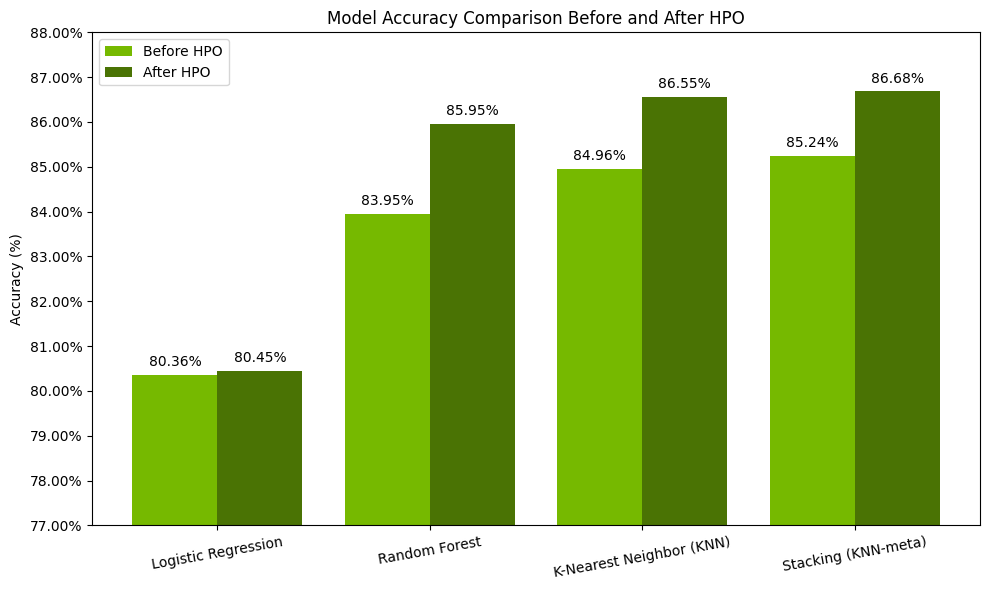

In [41]:
import pandas as pd
import matplotlib.pyplot as plt

# Recreate the DataFrame from your image
df = pd.DataFrame({
    "Logistic Regression": [80.36, 80.45],
    "Random Forest": [83.95, 85.95],
    "K-Nearest Neighbor (KNN)": [84.96, 86.55],
    "Stacking (KNN-meta)": [85.24, 86.68]
})

# Transpose the DataFrame to get model names as rows
df_transposed = df.T.reset_index()
df_transposed.columns = ['Model', 'Before HPO', 'After HPO']
df_transposed


# Plot configuration
bar_width = 0.4
x = range(len(df_transposed['Model']))

# Create the plot
plt.figure(figsize=(10, 6))
plt.bar([i - bar_width/2 for i in x], df_transposed['Before HPO'], 
        width=bar_width, label='Before HPO', color='#76B900')
plt.bar([i + bar_width/2 for i in x], df_transposed['After HPO'], 
        width=bar_width, label='After HPO', color='#4A7304')  # NVIDIA green

# Formatting
plt.xticks(ticks=x, labels=df_transposed['Model'], rotation=10)
plt.ylim(77, 88)
plt.yticks(ticks=range(77, 89), labels=[f"{i}.00%" for i in range(77, 89)])
plt.ylabel("Accuracy (%)")
plt.title("Model Accuracy Comparison Before and After HPO")
plt.legend()

# Annotate each bar with its value
for i in range(len(x)):
    plt.text(x[i] - bar_width/2, df_transposed['Before HPO'][i] + 0.2, 
             f"{df_transposed['Before HPO'][i]:.2f}%", ha='center')
    plt.text(x[i] + bar_width/2, df_transposed['After HPO'][i] + 0.2, 
             f"{df_transposed['After HPO'][i]:.2f}%", ha='center')

plt.tight_layout()
plt.show()
